## 4 - Predicting Property Maintenance Fines

Based on assignment 4 of [Applied Machine Learning in Python | Coursera](https://www.coursera.org/learn/python-machine-learning)


Goal: Predict the probability that a set of blight tickets will be paid on time

Data provided by Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)), the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) and the City of Detroit [Detroit Open Data Portal](https://data.detroitmi.gov/).
 

Each row in train.csv and test.csv.corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##  0. Original Data

In [2]:
target = ['compliance']

df_original = pd.read_csv('data/train.csv', encoding='iso-8859-1', dtype='unicode')
print("{} rows \n{} columns \ntarget: {}".format(*df_original.shape, target))

250306 rows 
34 columns 
target: ['compliance']


In [3]:
df_original.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0


### Explore and Clean Target

In [4]:
print(df_original[target].squeeze().value_counts(dropna=False))

0.0    148283
NaN     90426
1.0     11597
Name: compliance, dtype: int64


In [5]:
# Remove rows with NULL targets

df_original = df_original.dropna(subset=target)

print(df_original[target].squeeze().value_counts())
print(df_original.shape)

0.0    148283
1.0     11597
Name: compliance, dtype: int64
(159880, 34)


** Imbalanced target: the evaluation metric used in this problem is the Area Under the ROC Curve **

###  Split original data into training and validation test set

In [6]:
from sklearn.model_selection import train_test_split

df, df_test = train_test_split(
    df_original, test_size=0.2, stratify=df_original[target], random_state=0)

## 1. Data Processing

** To avoid data leakage, only the training dataframe, df, will be explored and processed here** 

In [7]:
def missing(df):
    """ Display missing values in a given dataframe """

    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if len(missing) == 0:
        print("No missing values found")
    else:
        print(missing)


missing(df_original)

violator_name                     26
violation_zip_code            159880
mailing_address_str_number      2558
mailing_address_str_name           3
state                             84
zip_code                           1
non_us_str_code               159877
hearing_date                     227
payment_date                  120269
collection_status             122983
grafitti_status               159880
dtype: int64


### Transform Data

#### Remove irrelevant features

In [8]:
df = df_original.copy()  # modified dataset


def remove_features(df):

    relevant_col = [
        'agency_name', 'violation_street_name', 'city', 'state', 'violator_name',
        'violation_code', 'late_fee', 'discount_amount', 'judgment_amount', 'disposition',
        'fine_amount', 'compliance'
    ]

    df = df[relevant_col]

    return df


df = remove_features(df)

print(df.shape)

(159880, 12)


#### Classify features

In [9]:
num = ['late_fee', 'discount_amount', 'judgment_amount', 'fine_amount']  # numerical features
cat = [col for col in df if col not in num if col not in target]  # categorical features

#### Fix types and Sort columns

In [10]:
def fix_types(df):

    for col in df[num + cat]:
        if col in num:
            df[col] = df[col].astype(np.float32)
        else:
            df[col] = df[col].astype('object')

    return df


fix_types(df)

df[target[0]] = df[target[0]].astype('object')  # fix target type

df = df[num + cat + target]  # sort columns

df.dtypes

late_fee                 float32
discount_amount          float32
judgment_amount          float32
fine_amount              float32
agency_name               object
violation_street_name     object
city                      object
state                     object
violator_name             object
violation_code            object
disposition               object
compliance                object
dtype: object

#### Remove low-frequency categorical values  (time-consuming)

In [11]:
def remove_lowfreq(df, values=None, ratio=0.001, show=False):
    """
    Remove low frequency categorical values appearing less than 'ratio' in its column of the 
    dataframe df. All fields of df must be categotical (objects)
    """

    for f in df:
        assert df[f].dtype == 'object', '{}: is not categorical'.format(col)

    df = df.copy()

    if values:

        for f in df:
            high_freq = values[f]
            low_freq = [v for v in df[f].unique() if v not in high_freq]

            if len(low_freq) > 0:
                df[f] = df[f].replace(low_freq, np.nan)
    else:

        values = dict()
        threshold = df.shape[0] * ratio

        for f in df:
            count = df[f].value_counts()
            high_freq = list(count[count >= threshold].index)
            low_freq = list(count[count < threshold].index)

            values[f] = high_freq

            if len(low_freq) > 0:
                df[f] = df[f].replace(low_freq, np.nan)
            if show:
                print(f, '\n', high_freq, '\n')

    return df, values


df[cat], cat_values = remove_lowfreq(df[cat])

#df.to_csv('data/training_filtered.csv', index=False)
#np.save('categorical_values.npy', cat_values)

In [12]:
# df = pd.read_csv('training_filtered.csv')
# cat_values = np.load('categorical_values.npy').item()

#  read from file changed target type to float
df['compliance'] = df['compliance'].astype('object')

#### Fill missing numerical values with the median

In [13]:
def fill_missing_numerical(df, value=None):
    
    for col in df:
        assert df[col].dtype != 'object', '{}: is not numerical'.format(col) 
    
    if value is None:
        value = df[numerical].median()
        
    df = df.fillna(value)
    
    return df, value

missing(df[num])
#df[num], numerical_fill = fill_missing_numerical(df[numerical]) # Not needed here

No missing values found


####  Fill missing categorical values with 'Other'


In [14]:
missing(df[cat])

agency_name                   1
violation_street_name     51310
city                      23340
state                      2118
violator_name            158483
violation_code             3193
dtype: int64


In [15]:
def fill_missing_categorical(df):

    df = df.copy()

    for col in df:
        assert df[col].dtype == 'object', '{}: is not categorical'.format(col)
        df[col].fillna('Other', inplace=True)

    return df


df[cat] = fill_missing_categorical(df[cat])

In [16]:
missing(df)

No missing values found


In [17]:
copy_df = df.copy()  # checkpoint

In [18]:
df.dtypes

late_fee                 float32
discount_amount          float32
judgment_amount          float32
fine_amount              float32
agency_name               object
violation_street_name     object
city                      object
state                     object
violator_name             object
violation_code            object
disposition               object
compliance                object
dtype: object

## 2 Prepare data for ML

In [19]:
# From now on use data instead of df
data = copy_df.copy()
data.head(2)

,late_fee,discount_amount,judgment_amount,fine_amount,agency_name,violation_street_name,city,state,violator_name,violation_code,disposition,compliance
0,25.0,0.0,305.0,250.0,"Buildings, Safety Engineering & Env Department",TYLER,CHICAGO,IL,Other,9-1-36(a),Responsible by Default,0.0
1,75.0,0.0,855.0,750.0,"Buildings, Safety Engineering & Env Department",CENTRAL,Detroit,MI,Other,Other,Responsible by Determination,1.0


### Scale numerical variables

In [20]:
def standardize(data, scale=None):
    """
    Standardize numerical variables (mean=0, std=1)
    
    Input: dataframe to standardize, dict(numerical_feature: [mean, std]) if a scale is used
    Output:  normal-distributed dataframe, dict(numerical_feature: [mean, std])
    
    Dataframe fields must be numerical
    """

    data = data.copy()

    if not scale:
        create_scale = True
        scale = {}
    else:
        create_scale = False

    for f in data:
        assert data[f].dtype != 'object', '{}: is not numerical'.format(f)
        if create_scale:
            mean, std = data[f].mean(), data[f].std()
            data[f] = (data[f].values - mean) / std
            scale[f] = [mean, std]
        else:
            data.loc[:, f] = (data[f] - scale[f][0]) / scale[f][1]
    return data, scale

In [21]:
data[num], scale = standardize(data[num])

### Create dummy features

In [22]:
def create_dummy(data, categorical, dummies=None):
    """ 
    Replace categorical features by dummy features (no target)  
    If no dummy list is used, a new one is created.  
    
    Input: dataframe, target list, dummy list
    Output: dataframe with categorical replaced by dummies, generated dummy list
     """

    data = data.copy()

    if not dummies:
        create_dummies = True
        dummies = []
    else:
        create_dummies = False

    found_dummies = []

    for f in categorical:

        assert data[f].dtype == 'object', '{}: is not categorical'.format(f)

        dummy = pd.get_dummies(data[f], prefix=f, drop_first=False)
        data = pd.concat([data, dummy], axis=1)
        data.drop(f, axis=1, inplace=True)

        found_dummies.extend(dummy)

    if not create_dummies:
        # remove new dummies not in given dummies
        new = set(found_dummies) - set(dummies)
        for n in new:
            data.drop(n, axis=1, inplace=True)

        # fill missing dummies with empty values (0)
        missing = set(dummies) - set(found_dummies)
        for m in missing:
            data[m] = 0

    else:
        dummies = found_dummies

    # set new columns to category
    for dummy in dummies:
        data[dummy] = data[dummy].astype('object')

    return data, dummies

In [23]:
data, dummies = create_dummy(data, cat)

model_features = [f for f in data if f not in target]  # save features order for test set

data.head(3)

,late_fee,discount_amount,judgment_amount,fine_amount,compliance,"agency_name_Buildings, Safety Engineering & Env Department",agency_name_Department of Public Works,agency_name_Detroit Police Department,agency_name_Health Department,agency_name_Other,...,violation_code_9-1-36(a),violation_code_9-1-43(a) - (Dwellin,violation_code_9-1-43(a) - (Structu,violation_code_9-1-81(a),violation_code_9-1-82(d) - (Dwellin,violation_code_Other,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default,disposition_Responsible by Determination
0,-0.127805,-0.045675,-0.155746,-0.158417,0.0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0.610824,-0.045675,0.584940,0.581605,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
5,-0.127805,-0.045675,-0.155746,-0.158417,0.0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


### Split the data into training and validation sets

In [24]:
def validation_split(data, val_size=0.25):
    
    train, test = train_test_split(data, test_size=val_size, 
                                   random_state=0, stratify = df_original[target])

    # Separate the data into features and target (x=features, y=target)
    x_train, y_train = train.drop(target, axis=1).values, train[target].values
    x_val, y_val = test.drop(target, axis=1).values, test[target].values
    # _nc: non-categorical yet (needs one-hot encoding)

    return x_train, y_train, x_val, y_val


X_train, y_train, X_val, y_val = validation_split(data, val_size=0.2)

X_train = X_train.astype(np.float16)
y_train = y_train.astype(np.float16)
X_val = X_val.astype(np.float16)
y_val = y_val.astype(np.float16)

X_train_val = np.vstack((X_train, X_val))
y_train_val = np.vstack((y_train, y_val))


print("train size \t X:{} \t Y:{}".format(X_train.shape, y_train.shape))
print("val size \t X:{} \t Y:{}".format(X_val.shape, y_val.shape))

train size 	 X:(127904, 444) 	 Y:(127904, 1)
val size 	 X:(31976, 444) 	 Y:(31976, 1)


In [25]:
def separate_x_y(data):
    """ Separate the data into features and target (x=features, y=target) """

    x, y = data.drop(target, axis=1).values, data[target].values
    x = x.astype(np.float16)
    y = y.astype(np.float16)
   
    return x, y


# X_train, y_train = separate_x_y(data)

## ML classifiers

In [26]:
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc


def scores(y_test, y_pred, plot=True):
    """ Print  different scores and plot ROC curve """
    print()
    print('ROC AUC: \t{:.2f}'.format(roc_auc_score(y_test, y_pred)))
    print('F1: \t\t{:.2f}'.format(f1_score(y_test, y_pred)))
    print('Accuracy: \t{:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: \t{:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: \t{:.2f}'.format(recall_score(y_test, y_pred)))
    print('\n Confusion matrix: \n', confusion_matrix(y_test, y_pred))

    if plot:

        fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
        roc_auc_lr = auc(fpr_lr, tpr_lr)

        plt.figure()
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr_lr, tpr_lr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')

### Dummy classifier

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.65 ms

ROC AUC: 	0.50
F1: 		0.00
Accuracy: 	0.93
Precision: 	0.00
Recall: 	0.00

 Confusion matrix: 
 [[29657     0]
 [ 2319     0]]


/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/angel/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


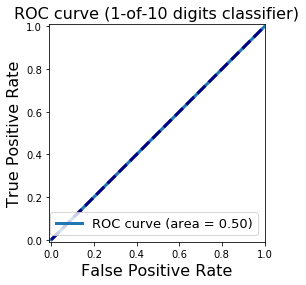

In [27]:
from sklearn.dummy import DummyClassifier

# Negative class (0) is most frequent
%time clf = DummyClassifier(strategy='most_frequent').fit(X_train, np.ravel(y_train))
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_pred = clf.predict(X_val).reshape([-1, 1])

scores(y_val, y_pred)

### Logistic classifier

CPU times: user 1.8 s, sys: 32 ms, total: 1.83 s
Wall time: 1.82 s

ROC AUC: 	0.74
F1: 		0.35
Accuracy: 	0.83
Precision: 	0.24
Recall: 	0.64

 Confusion matrix: 
 [[24905  4752]
 [  824  1495]]


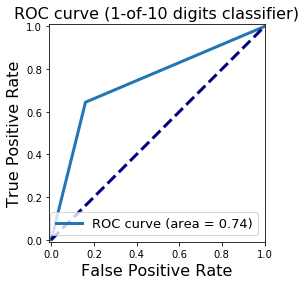

In [28]:
from sklearn.linear_model import LogisticRegression

clf_linear = None
%time clf_linear = LogisticRegression(class_weight='balanced').fit(X_train, np.ravel(y_train))
y_pred = clf_linear.predict(X_val).reshape([-1,1])

scores(y_val, y_pred)

In [29]:
from sklearn.model_selection import cross_val_score

print('CV ROC_AUC: \t{:.3f}'.format(
    np.mean(
        cross_val_score(
            clf_linear, X_train_val, np.ravel(y_train_val), cv=5, scoring='roc_auc'))))

CV ROC_AUC: 	0.808


### Decision Tree classifier

CPU times: user 660 ms, sys: 80 ms, total: 740 ms
Wall time: 641 ms

ROC AUC: 	0.74
F1: 		0.40
Accuracy: 	0.87
Precision: 	0.30
Recall: 	0.58

 Confusion matrix: 
 [[26559  3098]
 [  984  1335]]


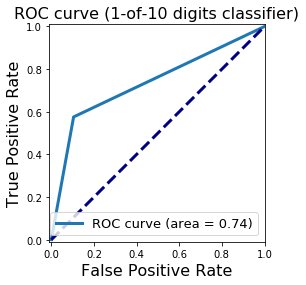

In [30]:
from sklearn.tree import DecisionTreeClassifier

%time clf_tree = DecisionTreeClassifier(max_depth=2, \
                                        class_weight='balanced').fit(X_train, y_train)
y_pred = clf_tree.predict(X_val).reshape([-1,1])

scores(y_val, y_pred)

In [31]:
print('CV ROC_AUC: \t{:.3f}'.format(
    np.mean(cross_val_score(clf_tree, X_train_val, np.ravel(y_train_val), cv=5,
                            scoring='roc_auc'))))

CV ROC_AUC: 	0.746


### Random Forest classifier

CPU times: user 964 ms, sys: 8 ms, total: 972 ms
Wall time: 508 ms

ROC AUC: 	0.74
F1: 		0.40
Accuracy: 	0.87
Precision: 	0.30
Recall: 	0.58

 Confusion matrix: 
 [[26569  3088]
 [  984  1335]]


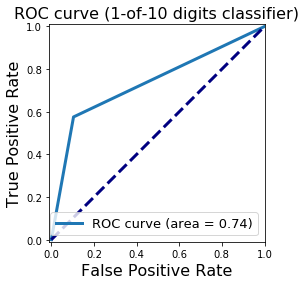

In [33]:
from sklearn.ensemble import RandomForestClassifier

%time clf_random_forest = RandomForestClassifier(n_estimators = 3, max_features=130, max_depth=4, \
                            class_weight='balanced', n_jobs=-1, random_state=0).fit(X_train, np.ravel(y_train))

y_pred = clf_random_forest.predict(X_val).reshape([-1, 1])

scores(y_val, y_pred)

In [34]:
print('CV ROC_AUC: \t{:.3f}'.format(
    np.mean(cross_val_score(clf_random_forest, X_train_val, np.ravel(y_train_val), cv=5,
                            scoring='roc_auc'))))

CV ROC_AUC: 	0.796


#### Grid search

In [35]:
from sklearn.model_selection import GridSearchCV

clf_grid_random_forest = RandomForestClassifier(
    n_estimators=30,
    class_weight='balanced',
    n_jobs=-1,
    random_state=0)

grid_values = {'max_features': [150, 180, 210], 'max_depth': [9,13,17]}

grid_clf_auc = GridSearchCV(clf_grid_random_forest, param_grid=grid_values, scoring='roc_auc')
grid_clf_auc.fit(X_train_val, np.ravel(y_train_val))

print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): {:.3f}'.format(grid_clf_auc.best_score_))

Grid best parameter (max. AUC):  {'max_depth': 13, 'max_features': 150}
Grid best score (AUC): 0.812


### Best classifier

In [36]:
%time clf_random_forest_opt = RandomForestClassifier(n_estimators = 30, max_features=150, \
                                max_depth=13, class_weight='balanced', n_jobs=-1, \
                                   random_state=0).fit(X_train_val, np.ravel(y_train_val))

CPU times: user 51.4 s, sys: 4 ms, total: 51.4 s
Wall time: 13.9 s


## Validation Test set

In [37]:
df_test.head(2)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
29156,48696,Department of Public Works,"Funchess, Mitchell","CORP, CONTIMORTGAGE",8200.0,HEYDEN,NaN,3815,WEST TEMPLE,SALT LAKE CITY,...,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,IN COLLECTION,NaN,non-compliant by no payment,0.0
125262,152329,"Buildings, Safety Engineering & Env Department","Doetsch, James","JACKSON, THEO",13821.0,GLENWOOD,NaN,1464,PO BOX,DETROIT,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0


#### Process validation test data with training parameters (no data leakage)

In [38]:
df_test = remove_features(df_test)
df_test[cat], _ = remove_lowfreq(df_test[cat], values=cat_values)
df_test[cat] = fill_missing_categorical(df_test[cat])
missing(df_test)

df_test = fix_types(df_test)
df_test[num], _ = standardize(df_test[num], scale)
df_test, _ = create_dummy(df_test, cat, dummies)

No missing values found


In [39]:
df_test = df_test[model_features+target] # sort columns to match training features order

In [40]:
X_test, y_test = separate_x_y(df_test)

#### Validation test accuracies

In [41]:
for clf in [clf_linear, clf_tree, clf_random_forest, clf_random_forest_opt]:

    y_pred = clf.predict(X_test).reshape([-1, 1])
    print(clf)
    print('ROC AUC: \t{:.2f} \n'.format(roc_auc_score(y_test, y_pred)))

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
ROC AUC: 	0.74 

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
ROC AUC: 	0.74 

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features=130,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=3, n_jobs=-1

## Final Blight model

The best model will be trained with all data from `train.csv` to generate compliance probabilities of `test.csv`

In [42]:
df = df_original.copy()  # From train.csv
df_final_test = pd.read_csv('data/test.csv', encoding='iso-8859-1', dtype='unicode')
df_final_test.shape

(61001, 27)

In [43]:
test_ticket_id = df_final_test['ticket_id'].values

In [44]:
missing(df_final_test)

violator_name                    28
violation_zip_code            36977
mailing_address_str_number     1014
mailing_address_str_name          3
city                              1
state                           331
zip_code                          3
non_us_str_code               61001
hearing_date                   2197
grafitti_status               58780
dtype: int64


#### Process the training features

Same pipeline as the one used with the above training set

In [45]:
df = remove_features(df)
df[cat], cat_values = remove_lowfreq(df[cat])  # time-consuming
df[cat] = fill_missing_categorical(df[cat])

df= fix_types(df)
df[num], _ = standardize(df[num], scale)
df, _ = create_dummy(df, cat, dummies)    

In [46]:
missing(df)

No missing values found


In [47]:
model_features = [f for f in df if f not in target]  # save features order for test set

In [48]:
X_train, y_train = separate_x_y(df)

#### Train the model

In [49]:
%time clf_random_forest_opt = RandomForestClassifier(n_estimators = 30, max_features=150, \
                                    max_depth=13, class_weight='balanced', n_jobs=-1, \
                                   random_state=0).fit(X_train, np.ravel(y_train))

CPU times: user 43.5 s, sys: 56 ms, total: 43.6 s
Wall time: 11.9 s


#### Process the test features with training parameters (no data leakage)

Same pipeline as the one used with the above test set

In [50]:
df_final_test = pd.concat([df_final_test,pd.DataFrame(columns=target)]) # add empty target column


In [51]:
df_final_test = remove_features(df_final_test)
df_final_test[cat], _ = remove_lowfreq(df_final_test[cat], values=cat_values)
df_final_test[cat] = fill_missing_categorical(df_final_test[cat])
df_final_test= fix_types(df_final_test)
df_final_test[num], _ = standardize(df_final_test[num], scale)
df_final_test, _ = create_dummy(df_final_test, cat, dummies)

missing(df_final_test)

compliance    61001
dtype: int64


In [52]:
# sort columns to match training features order
df_final_test = df_final_test[model_features+target] 

In [53]:
X_final_test, y_final_test = separate_x_y(df_final_test)

#### Predict the probabilities of compliance of test data

In [54]:
df_final_test['target_proba'] = clf_random_forest_opt.predict_proba(X_final_test)[:,1]

In [55]:
results = pd.Series(df_final_test['target_proba'].values, index = test_ticket_id)
results.head()

284932    0.734812
285362    0.089062
285361    0.383716
285338    0.425887
285346    0.617245
dtype: float64